# UNet

In [6]:
import torch
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torch.nn.functional import relu
from tqdm.auto import tqdm
import torch.optim as optim
from utils.dataset import CocoDataset
from utils.plots import plot_l, plot_a, plot_b, plot_rgb, reconstruct_lab, plot_predicted_image, plot_ab

In [7]:
torch.backends.mps.is_available()

True

In [8]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'mps'

## Data import

In [9]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [10]:
path = '../train2014'
dataset = CocoDataset(path, transform=transform)

Found 82783 images.


In [11]:
image, l_channel, a_channel, b_channel, ab_channels = dataset[0]

In [12]:
image.shape, l_channel.shape, a_channel.shape, b_channel.shape, ab_channels.shape

(torch.Size([3, 64, 64]),
 torch.Size([1, 64, 64]),
 torch.Size([64, 64]),
 torch.Size([64, 64]),
 torch.Size([2, 64, 64]))

## Data preparation

In [13]:
test_size = int(.2 * len(dataset))
train_size = len(dataset) - test_size

In [14]:
torch.manual_seed(42)
train, test = random_split(dataset, [train_size, test_size], torch.Generator().manual_seed(42))

train_loader = DataLoader(train, batch_size=64, shuffle=True)
test_loader = DataLoader(test, batch_size=64, shuffle=True)

In [15]:
for x in train_loader:
    print(len(x))
    print(f"Image shape {x[0].shape}\nL shape {x[1].shape}\nA shape {x[2].shape}\nB shape {x[3].shape}\nAB shape {x[4].shape}")
    break

5
Image shape torch.Size([64, 3, 64, 64])
L shape torch.Size([64, 1, 64, 64])
A shape torch.Size([64, 64, 64])
B shape torch.Size([64, 64, 64])
AB shape torch.Size([64, 2, 64, 64])


## UNet model

In [45]:
torch.manual_seed(42)
train_size = 10000
small_train, _ = random_split(train, [train_size, len(train) - train_size], torch.Generator().manual_seed(42))
small_train_loader = DataLoader(small_train, batch_size=64, shuffle=True)
test_size = 2000
small_test, _ = random_split(test, [test_size, len(test) - test_size], torch.Generator().manual_seed(42))
small_test_loader = DataLoader(small_test, batch_size=64, shuffle=True)

In [46]:
len(small_train), len(small_test)

(10000, 2000)

### Training

In [47]:
def double_convolution(in_channels, out_channels):
    """
    In the original paper implementation, the convolution operations were
    not padded but we are padding them here. This is because, we need the 
    output result size to be same as input size.
    """
    conv_op = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )
    return conv_op

In [48]:
class UNet(nn.Module):
    def __init__(self, num_classes=2):
        super(UNet, self).__init__()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        # Contracting path.
        # Each convolution is applied twice.
        self.down_convolution_1 = double_convolution(1, 64)
        self.down_convolution_2 = double_convolution(64, 128)
        self.down_convolution_3 = double_convolution(128, 256)
        self.down_convolution_4 = double_convolution(256, 512)
        self.down_convolution_5 = double_convolution(512, 1024)
        # Expanding path.
        self.up_transpose_1 = nn.ConvTranspose2d(
            in_channels=1024, out_channels=512,
            kernel_size=2, 
            stride=2)
        # Below, `in_channels` again becomes 1024 as we are concatinating.
        self.up_convolution_1 = double_convolution(1024, 512)
        self.up_transpose_2 = nn.ConvTranspose2d(
            in_channels=512, out_channels=256,
            kernel_size=2, 
            stride=2)
        self.up_convolution_2 = double_convolution(512, 256)
        self.up_transpose_3 = nn.ConvTranspose2d(
            in_channels=256, out_channels=128,
            kernel_size=2, 
            stride=2)
        self.up_convolution_3 = double_convolution(256, 128)
        self.up_transpose_4 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64,
            kernel_size=2, 
            stride=2)
        self.up_convolution_4 = double_convolution(128, 64)
        # output => `out_channels` as per the number of classes.
        self.out = nn.Conv2d(
            in_channels=64, out_channels=num_classes, 
            kernel_size=1
        ) 
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        down_1 = self.down_convolution_1(x)
        down_2 = self.max_pool2d(down_1)
        down_3 = self.down_convolution_2(down_2)
        down_4 = self.max_pool2d(down_3)
        down_5 = self.down_convolution_3(down_4)
        down_6 = self.max_pool2d(down_5)
        down_7 = self.down_convolution_4(down_6)
        down_8 = self.max_pool2d(down_7)
        down_9 = self.down_convolution_5(down_8)        
        
        up_1 = self.up_transpose_1(down_9)
        x = self.up_convolution_1(torch.cat([down_7, up_1], 1))
        up_2 = self.up_transpose_2(x)
        x = self.up_convolution_2(torch.cat([down_5, up_2], 1))
        up_3 = self.up_transpose_3(x)
        x = self.up_convolution_3(torch.cat([down_3, up_3], 1))
        up_4 = self.up_transpose_4(x)
        x = self.up_convolution_4(torch.cat([down_1, up_4], 1))
        out = self.out(x)
        x = self.sigmoid(out)
        return x

In [49]:
model = UNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [50]:
NUM_EPOCHS = 10
train_losses = []
test_losses = []
for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    test_loss =  0.0

    model.train()
    progress_bar = tqdm(small_train_loader, desc=f'Epoch {epoch + 1}/{NUM_EPOCHS}', leave=True)
    for _, l_channels, _, _, ab_channels in progress_bar:
        l_channels = l_channels.to(device)
        ab_channels = ab_channels.to(device)
        
        optimizer.zero_grad()
        outputs = model(l_channels)
        loss = criterion(outputs, ab_channels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        progress_bar.set_postfix(loss=(running_loss / (progress_bar.n + 1)))
    
    train_losses.append(running_loss / len(small_train_loader))
    print(f"Epoch {epoch + 1}, Train Loss: {train_losses[-1]}")
    
    # test loop
    model.eval()
    with torch.no_grad():
        for _, l_channels, _, _, ab_channels in tqdm(small_test_loader, desc='Testing', leave=True):
            l_channels = l_channels.to(device)
            ab_channels = ab_channels.to(device)
            
            outputs = model(l_channels)
            loss = criterion(outputs, ab_channels)
            test_loss += loss.item()
        
    test_loss /= len(small_test_loader)
    test_losses.append(test_loss)
    print(f"Epoch {epoch + 1}, Validation Loss: {test_loss}")
    
print('Finished Training')


Epoch 1/10: 100%|██████████| 157/157 [03:26<00:00,  1.32s/it, loss=0.256]


Epoch 1, Train Loss: 0.2563670000660524


Testing: 100%|██████████| 32/32 [00:21<00:00,  1.48it/s]


Epoch 1, Validation Loss: 0.2628021780401468


Epoch 2/10: 100%|██████████| 157/157 [03:46<00:00,  1.44s/it, loss=0.264]


Epoch 2, Train Loss: 0.26359715924900806


Testing: 100%|██████████| 32/32 [00:20<00:00,  1.60it/s]


Epoch 2, Validation Loss: 0.26282296050339937


Epoch 3/10: 100%|██████████| 157/157 [03:26<00:00,  1.32s/it, loss=0.264]


Epoch 3, Train Loss: 0.2636120998935335


Testing: 100%|██████████| 32/32 [00:21<00:00,  1.48it/s]


Epoch 3, Validation Loss: 0.262677812948823


Epoch 4/10: 100%|██████████| 157/157 [03:43<00:00,  1.43s/it, loss=0.264]


Epoch 4, Train Loss: 0.2636401833622319


Testing: 100%|██████████| 32/32 [00:20<00:00,  1.53it/s]


Epoch 4, Validation Loss: 0.2627892242744565


Epoch 5/10: 100%|██████████| 157/157 [03:54<00:00,  1.50s/it, loss=0.264]


Epoch 5, Train Loss: 0.26361600171988175


Testing: 100%|██████████| 32/32 [00:20<00:00,  1.56it/s]


Epoch 5, Validation Loss: 0.2628787523135543


Epoch 6/10:  18%|█▊        | 29/157 [00:53<03:54,  1.83s/it, loss=0.264]


KeyboardInterrupt: 

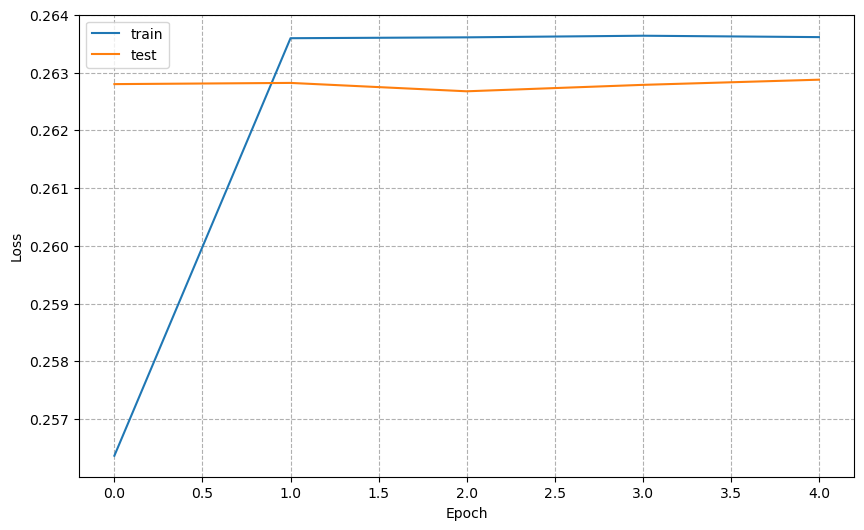

In [51]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(linestyle = "--")
plt.legend()
plt.show()

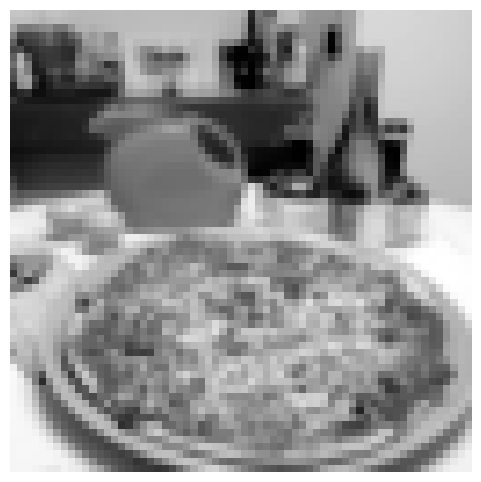

In [52]:
plot_l(dataset[76543][1])

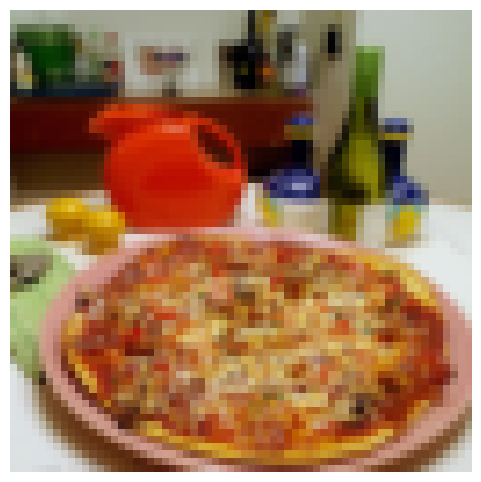

In [53]:
plot_rgb(dataset[76543][0])

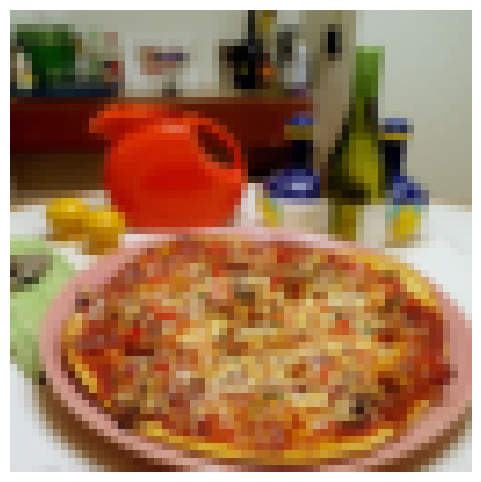

In [54]:
reconstruct_lab(dataset[76543][1], dataset[76543][-1])

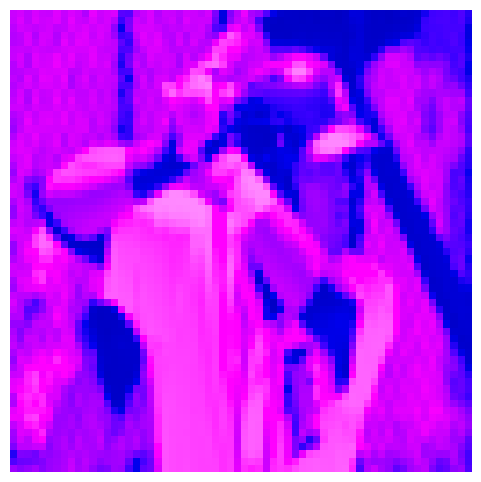

In [55]:
input = dataset[0][1].to(device).unsqueeze(0)
ab = model(input).squeeze(0)
reconstruct_lab(dataset[0][1].to(device).detach().cpu(), ab.detach().cpu())